### In this notebook, I've implemented the [following](https://arxiv.org/pdf/1608.04667.pdf) paper. The aim is to contruct a denoising autoencoder yielding superior results than that from Median filtering. Dental X-ray dataset is used for training and testing.

In [249]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/*'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Dataset/16.jpg
/content/drive/MyDrive/Dataset/14.jpg
/content/drive/MyDrive/Dataset/15.jpg
/content/drive/MyDrive/Dataset/120.jpg
/content/drive/MyDrive/Dataset/12.jpg
/content/drive/MyDrive/Dataset/119.jpg
/content/drive/MyDrive/Dataset/118.jpg
/content/drive/MyDrive/Dataset/13.jpg
/content/drive/MyDrive/Dataset/117.jpg
/content/drive/MyDrive/Dataset/116.jpg
/content/drive/MyDrive/Dataset/113.jpg
/content/drive/MyDrive/Dataset/115.jpg
/content/drive/MyDrive/Dataset/114.jpg
/content/drive/MyDrive/Dataset/112.jpg
/content/drive/MyDrive/Dataset/110.jpg
/content/drive/MyDrive/Dataset/11.jpg
/content/drive/MyDrive/Dataset/111.jpg
/content/drive/MyDrive/Dataset/108.jpg
/content/drive/MyDrive/Dataset/109.jpg
/content/drive/MyDrive/Dataset/107.jpg
/content/drive/MyDrive/Dataset/105.jpg
/content/drive/MyDrive/Dataset/106.jpg
/content/drive/MyDrive/Dataset/103.jpg
/content/drive/MyDrive/Dataset/104.jpg
/content/drive/MyDrive/Dataset/100.jpg
/content/drive/MyDrive/Dataset/

In [250]:
from keras.preprocessing import image

In [251]:
train_images = sorted(os.listdir('/content/drive/MyDrive/Dataset/*'))

In [252]:
# Assuming train_images is a list of image filenames
train_image = []
# Path to the directory containing images
base_dir = '/content/drive/MyDrive/Dataset/*'

for im in train_images:
    img_path = os.path.join(base_dir, im)  # Construct the full file path
    try:
        img = image.load_img(img_path, target_size=(64, 64), color_mode='grayscale')  # Load image
        img = image.img_to_array(img)  # Convert image to array
        img = img / 255.0  # Normalize image
        train_image.append(img)  # Append to list
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

train_df = np.array(train_image)  # Convert list to numpy array

### Constructing the dataset in the required format

In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Defining a plot function

In [254]:
import matplotlib.pyplot as plt

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
    plt.show()

### Defining a function for Noice addition. 0.07 is multiplied as it is the fraction of noice that we want in our picture.

In [255]:
def add_noice(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.07
    return noisy

In [256]:
noised_df= []

for img in train_df:
    noisy= add_noice(img)
    noised_df.append(noisy)

In [257]:
noised_df= np.array(noised_df)

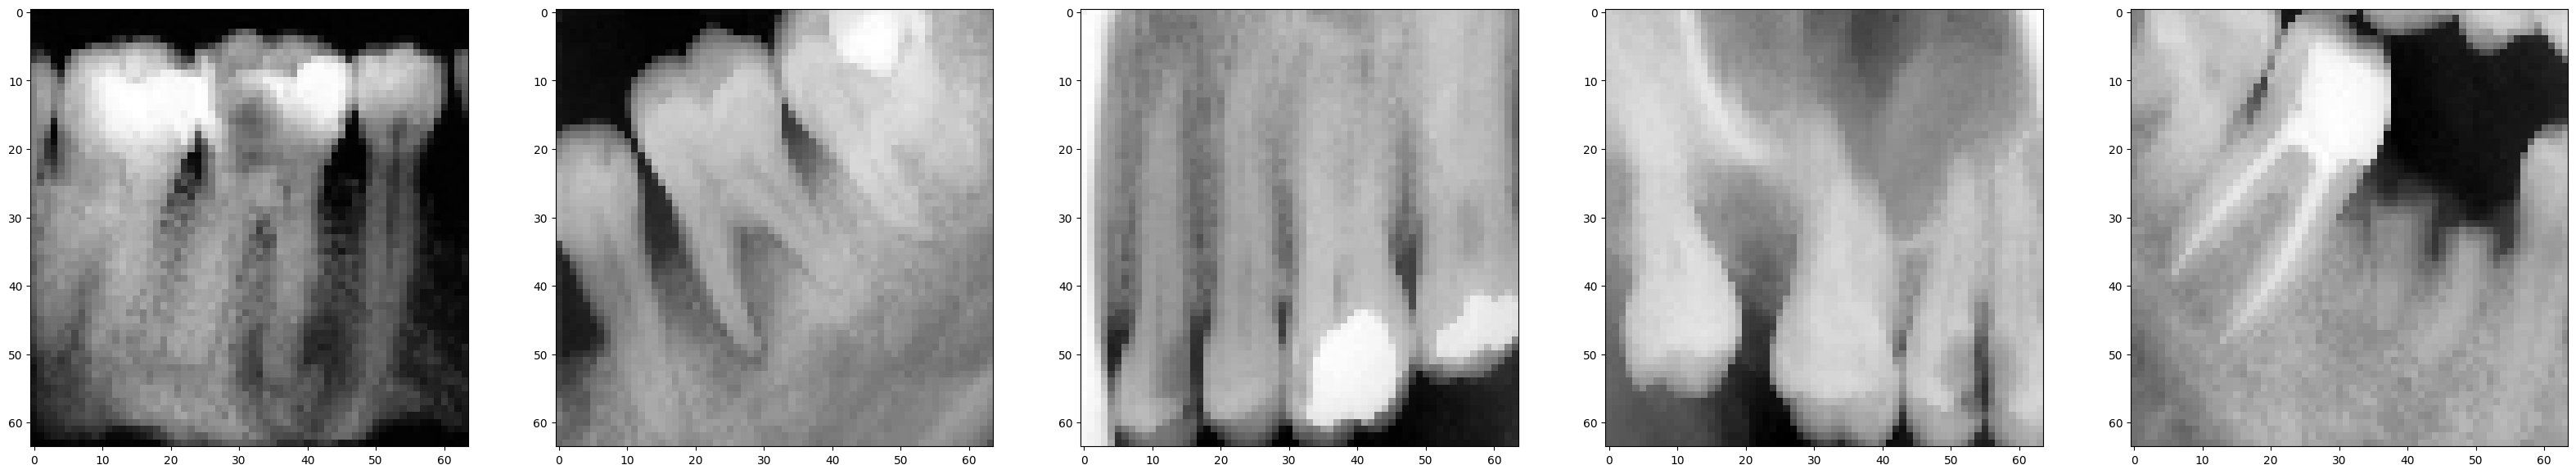

In [258]:
show_img(train_df)

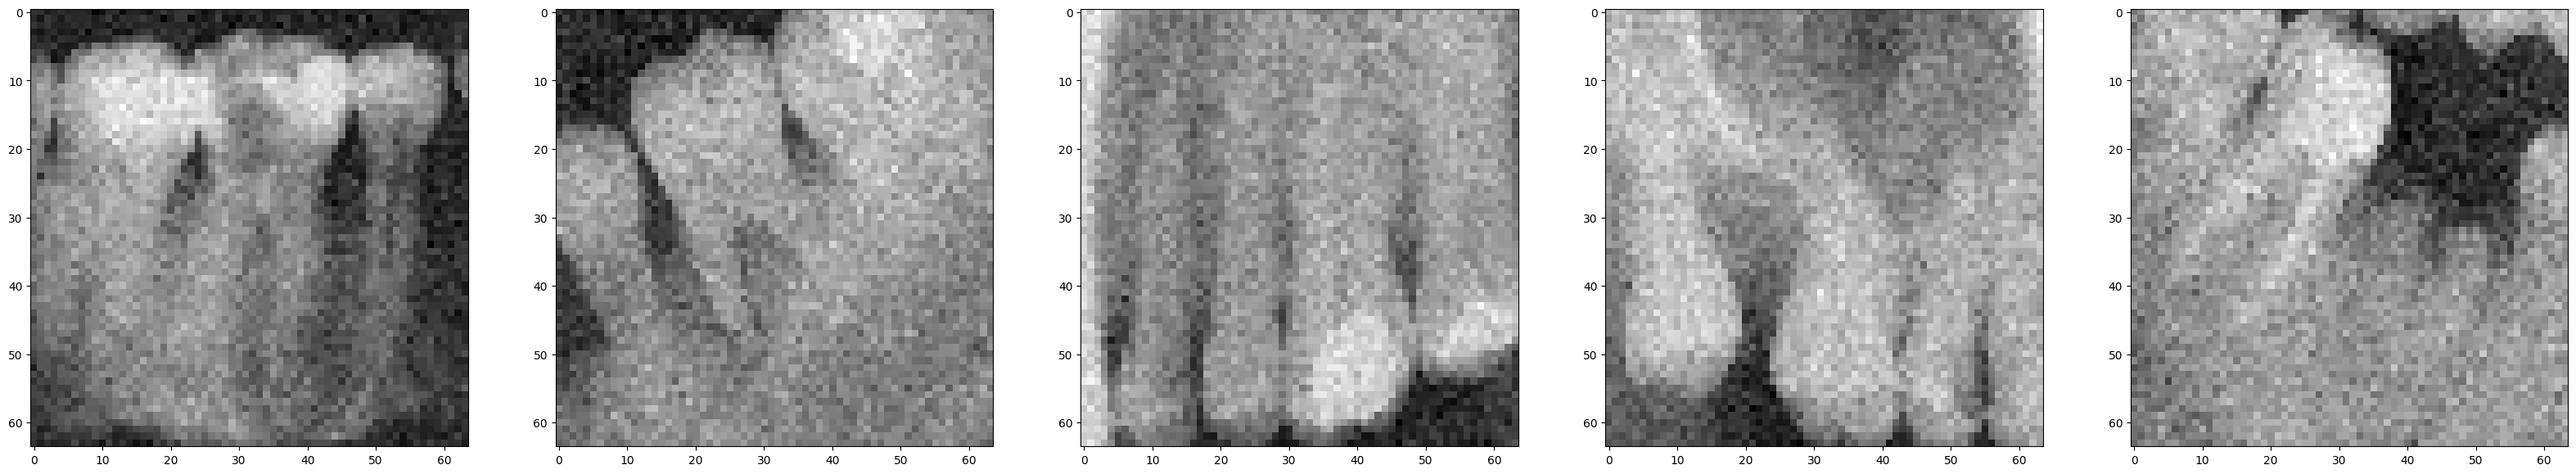

In [259]:
show_img(noised_df)

In [260]:
noised_df.shape

(120, 64, 64, 1)

In [261]:
train_df.shape

(120, 64, 64, 1)

In [262]:
xnoised= noised_df[0:100]
xtest= noised_df[100:]

In [263]:
xnoised.shape

(100, 64, 64, 1)

### Defining the model architecture as per the design suggested in the paper

In [264]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

def autoencoder():

    input_img = Input(shape=(64,64,1), name='image_input')

    #enoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

In [265]:
model= autoencoder()
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 16, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 32, 32, 64)        0  

In [266]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

### Paper suggests to set epoch=100, but, due to less computational power available and small dataset, we'll use 40 epochs with a batch size of 10.

In [267]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=40, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/40
10/10 [==============================] - 4s 311ms/step - loss: 0.6734 - val_loss: 0.6288
Epoch 2/40
10/10 [==============================] - 5s 457ms/step - loss: 0.6107 - val_loss: 0.5930
Epoch 3/40
10/10 [==============================] - 3s 307ms/step - loss: 0.5891 - val_loss: 0.5846
Epoch 4/40
10/10 [==============================] - 3s 272ms/step - loss: 0.5788 - val_loss: 0.5772
Epoch 5/40
10/10 [==============================] - 3s 272ms/step - loss: 0.5734 - val_loss: 0.5749
Epoch 6/40
10/10 [==============================] - 3s 283ms/step - loss: 0.5721 - val_loss: 0.5733
Epoch 7/40
10/10 [==============================] - 4s 440ms/step - loss: 0.5683 - val_loss: 0.5716
Epoch 8/40
10/10 [==============================] - 3s 319ms/step - loss: 0.5665 - val_loss: 0.5665
Epoch 9/40
10/10 [==============================] - 3s 271ms/step - loss: 0.5639 - val_loss: 0.5647
Epoch 10/40
10/10 [==============================] - 3s 276ms/step - loss: 0.5630 - val_loss: 0.5636

In [268]:
xtrain= train_df[100:]

## Plotting the predictions.

### First row:   Original image
### Second row:  Noice image
### Third row:   Denoised image using Autoencoder
### Fourth row:  Median filter image

1/1 [==============================] - 0s 131ms/step


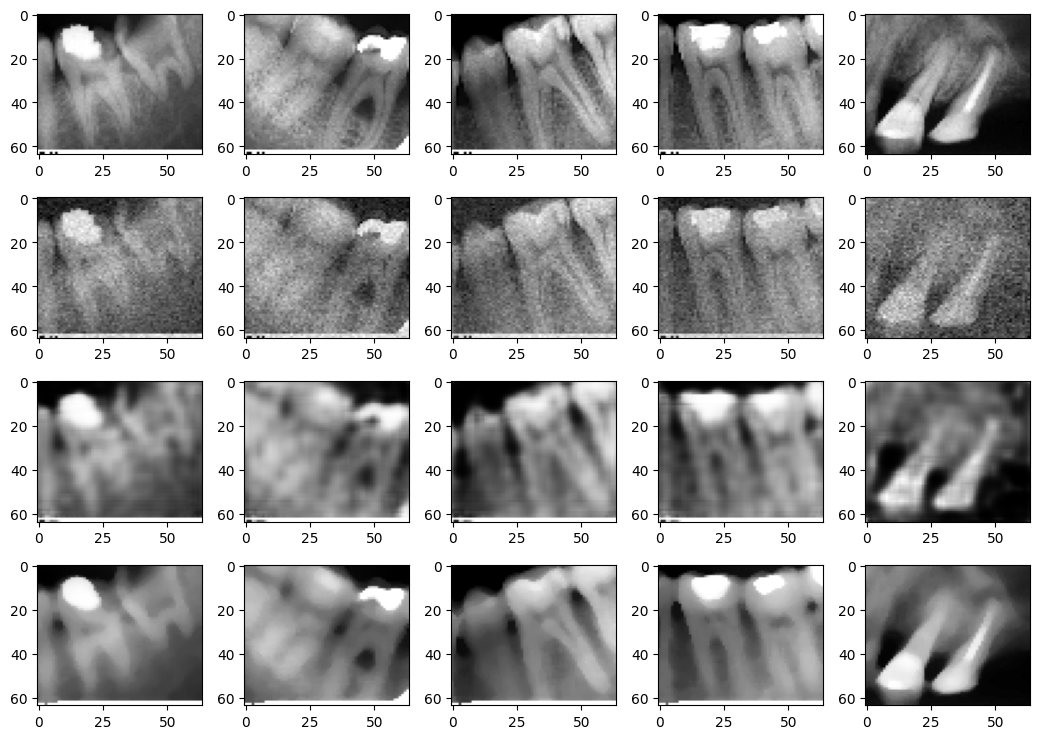

In [269]:
import cv2

pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (64,64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (64,64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')

    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

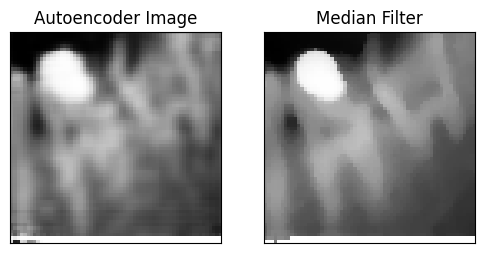

In [270]:
new_image = cv2.medianBlur(xtrain[0], (5))
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(pred[0].reshape(64,64), cmap='gray')
plt.title('Autoencoder Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(new_image, cmap='gray')
plt.title('Median Filter')
plt.xticks([])
plt.yticks([])
plt.show()

In [272]:
from math import log10, sqrt

def PSNR(original, denoiced):
    mse = np.mean((original - denoiced) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr**0.75

value1 = PSNR(xtest[0], new_image)
value2 = PSNR(xtest[0], pred[0])

print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

PSNR value for Denoised image is 24.22264819186889 dB while for Median filtered image is 21.13990519697164 dB
